# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [217]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [218]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [219]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [220]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/My_notebook_printemps/network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [221]:
## define SPARQL enpoint
endpoint = "https://ag1khc5dnlqgdc0c.allegrograph.cloud/repositories/Astronauts"

In [222]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/projhistoire/Projet-Histoire/blob/main/Wikidata/graph/imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 


"""

In [223]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


2000
[['http://www.wikidata.org/entity/Q110916469',
  'Scott Poteet',
  '1973',
  'education',
  'http://www.wikidata.org/entity/Q4697817',
  'Air Command and Staff College',
  '1',
  'staff college'],
 ['http://www.wikidata.org/entity/Q110916469',
  'Scott Poteet',
  '1973',
  'education',
  'http://www.wikidata.org/entity/Q7116352',
  'Oyster River High School',
  '1',
  'high school'],
 ['http://www.wikidata.org/entity/Q110916469',
  'Scott Poteet',
  '1973',
  'education',
  'http://www.wikidata.org/entity/Q49207',
  'University of New Hampshire',
  '3',
  'public research university | public educational institution of the United '
  'States | land-grant university']]


## Inspect the data


In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  2000


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q104865,Vladimir Komarov,1927,education,http://www.wikidata.org/entity/Q4238545,Krasnodar Higher Military Aviation School of P...,1,military school
11,http://www.wikidata.org/entity/Q104865,Vladimir Komarov,1927,education,http://www.wikidata.org/entity/Q4094046,Borisoglebsk Higher Aviators School,1,military school
12,http://www.wikidata.org/entity/Q106286882,Christopher Sembroski,1979,education,http://www.wikidata.org/entity/Q5370252,"Embry–Riddle Aeronautical University, Daytona ...",1,private not-for-profit educational institution


### Distribution of relationships in relation to birthYears of organisations members

In [9]:
l_50 = list(range(1751, 2051, 50))
print(l_50)

[1751, 1801, 1851, 1901, 1951, 2001]


In [10]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [11]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [12]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q1018622,Byron K. Lichtenberg,1948,education,http://www.wikidata.org/entity/Q49108,Massachusetts Institute of Technology,6,university | space grant institution | institu...,1941-1960
5,http://www.wikidata.org/entity/Q104859,Michael Collins,1930,education,http://www.wikidata.org/entity/Q49126,Harvard Business School,2,business school | organization,1921-1940
10,http://www.wikidata.org/entity/Q104865,Vladimir Komarov,1927,education,http://www.wikidata.org/entity/Q4238545,Krasnodar Higher Military Aviation School of P...,1,military school,1921-1940


In [13]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1901-1920      4
1921-1940    434
1941-1960    944
1961-1980    487
1981-2000    131
dtype: int64


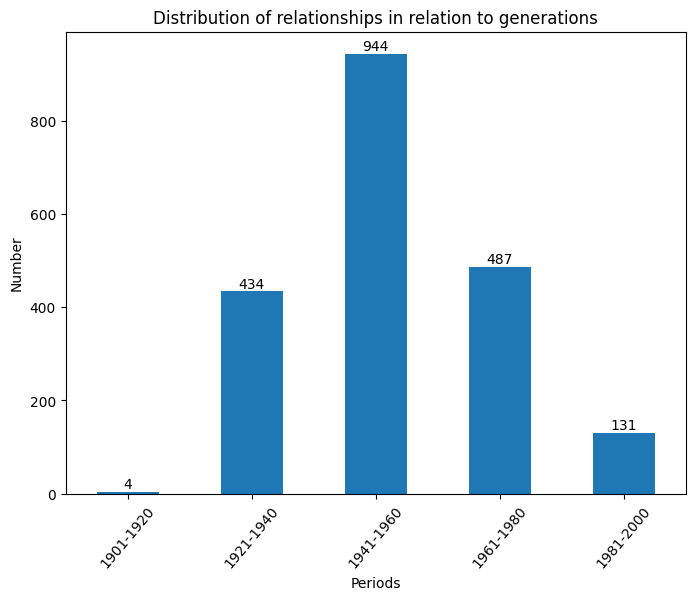

In [14]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [15]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1894
employment     106
dtype: int64


In [16]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

     periods    relaType  size
0  1901-1920   education     4
1  1921-1940   education   419
2  1921-1940  employment    15
3  1941-1960   education   875
4  1941-1960  employment    69
5  1961-1980   education   474
6  1961-1980  employment    13
7  1981-2000   education   122
8  1981-2000  employment     9


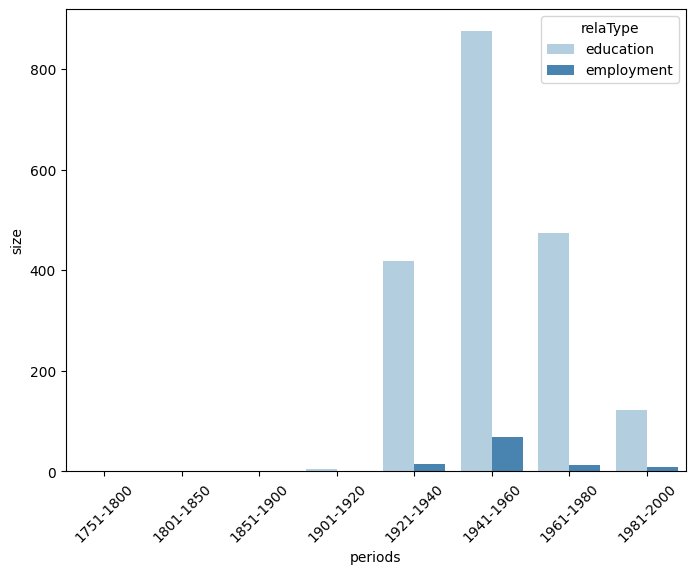

In [17]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [18]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


2000
[['academic publisher',
  'colonial colleges',
  'private not-for-profit educational institution',
  'private university',
  'research university'],
 ['academic publisher',
  'institute of technology',
  'institute of technology',
  'private not-for-profit educational institution',
  'space grant institution',
  'university'],
 ['national research university',
  'open-access publisher',
  'publishing company']]


In [19]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q1018622,Byron K. Lichtenberg,1948,education,http://www.wikidata.org/entity/Q49108,Massachusetts Institute of Technology,6,academic publisher | institute of technology |...,1941-1960,"[academic publisher, institute of technology, ..."
5,http://www.wikidata.org/entity/Q104859,Michael Collins,1930,education,http://www.wikidata.org/entity/Q49126,Harvard Business School,2,business school | organization,1921-1940,"[business school, organization]"
10,http://www.wikidata.org/entity/Q104865,Vladimir Komarov,1927,education,http://www.wikidata.org/entity/Q4238545,Krasnodar Higher Military Aviation School of P...,1,military school,1921-1940,[military school]


#### Organisations' types distribution

In [20]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
high school                                                                                                                         214
military school                                                                                                                     101
flight school                                                                                                                        97
census-designated place in the united states | naval academy | observatory | public educational institution of the united states     62
land-grant university | public educational institution of the united states | public research university                             57
high school | public school                                                                                                          56
university                                                                                                                           55
open-access publisher | private not-for

#### Save dataframe to CSV

In [109]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

#### Reload from CSV

In [22]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

2000


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1018622,Byron K. Lichtenberg,1948,education,http://www.wikidata.org/entity/Q49114,Brown University,5,academic publisher | colonial colleges | priva...,1941-1960,"['academic publisher', 'colonial colleges', 'p..."
1,http://www.wikidata.org/entity/Q1018622,Byron K. Lichtenberg,1948,education,http://www.wikidata.org/entity/Q49108,Massachusetts Institute of Technology,6,academic publisher | institute of technology |...,1941-1960,"['academic publisher', 'institute of technolog..."


## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [23]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,high school,214,1
1,military school,101,1
2,flight school,97,1
3,census-designated place in the united states |...,62,4
4,land-grant university | public educational ins...,57,3
5,high school | public school,56,2
6,university,55,1
7,open-access publisher | private not-for-profit...,54,4
8,public educational institution of the united s...,51,2
9,public educational institution of the united s...,51,2


In [110]:
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [111]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
0,http://www.wikidata.org/entity/Q1018622,Byron K. Lichtenberg,1948,education,http://www.wikidata.org/entity/Q49114,Brown University,5,academic publisher | colonial colleges | priva...,1941-1960,"['academic publisher', 'colonial colleges', 'p...",private university


In [112]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'polyt' in x:
        val = 'institute of technology'    
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'military academy' in x:
        val = 'educational institution' 
    elif 'naval academy' in x:
        val = 'educational institution'        
    elif 'art academy' in x:
        val = 'educational institution' 
    elif 'faculty' in x:
        val = 'university'  # could also be 'faculty'
    elif 'academic dep' in x:
        val =  'university'  # could also be 'faculty'    
    elif 'college' in x:
        val = 'educational institution'   # could also be 'college'             
    elif 'gymnas' in x:
        val = 'educational institution'   # could also be 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'nonprofit organization' in x:
        val = 'scientific organisation'    
    elif 'national academy' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'observatory' in x:
        val = 'astronomical observatory'  
    elif 'higher education' in x:
        val = 'educational institution'
    elif 'school' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academic institution' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academy' in x:
        val = 'learned society'
    elif 'society' in x:
        val = 'learned society'      
    elif 'company' in x \
                or 'business'  in x \
                or 'entrepr' in x:
        val = 'company'
    elif 'government' in x :
        val = 'governmenmt agency'         
    elif 'publish' in x :
        val = 'publisher_edition'     
    elif 'journal' in x :
        val = 'publisher_edition'
    elif 'periodical' in x :
        val = 'publisher_edition'    
    else:
        val = 'not classified organisation'

    return val        

In [113]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q104859,Michael Collins,1930,education,http://www.wikidata.org/entity/Q4671107,Academia del Perpetuo Socorro,1,school,1921-1940,['school'],educational institution
8,http://www.wikidata.org/entity/Q104859,Michael Collins,1930,education,http://www.wikidata.org/entity/Q3428253,U.S. Air Force Test Pilot School,1,flight school,1921-1940,['flight school'],educational institution
9,http://www.wikidata.org/entity/Q104865,Vladimir Komarov,1927,education,http://www.wikidata.org/entity/Q1934904,Zhukovsky Air Force Engineering Academy,3,educational institution | military academy | m...,1921-1940,"['educational institution', 'military academy'...",educational institution


In [114]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
0,educational institution,899
9,university,626
4,private university,151
5,public university,151
1,institute of technology,103
2,learned society,47
3,not classified organisation,13
7,research organisation,5
6,research facility,4
8,scientific organisation,1


In [115]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
243,open-access publisher | private not-for-profit...,private university,54,4
283,public educational institution of the united s...,university,51,2
289,public educational institution of the united s...,university,51,2


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [116]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType


# Create graphs

In [117]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1894
employment     106
dtype: int64


### Prepare the dataframe

In [118]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

2000


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [119]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
312,http://www.wikidata.org/entity/Q3428253,U.S. Air Force Test Pilot School,flight school,educational institution,95
30,http://www.wikidata.org/entity/Q1128819,United States Naval Test Pilot School,military school,educational institution,81
569,http://www.wikidata.org/entity/Q559549,United States Naval Academy,census-designated place in the united states |...,educational institution,62
432,http://www.wikidata.org/entity/Q49108,Massachusetts Institute of Technology,academic publisher | institute of technology |...,institute of technology,50
82,http://www.wikidata.org/entity/Q1331280,United States Air Force Academy,air force academy | field operating agency,learned society,44
141,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,military university | open-access publisher | ...,university,43
355,http://www.wikidata.org/entity/Q41506,Stanford University,open-access publisher | private not-for-profit...,private university,29
186,http://www.wikidata.org/entity/Q1719898,Moscow Aviation Institute,national research university | open-access pub...,university,28
861,http://www.wikidata.org/entity/Q9219,United States Military Academy,direct reporting unit | military academy | mil...,educational institution,28
240,http://www.wikidata.org/entity/Q217741,Purdue University,land-grant university | public educational ins...,university,25


In [120]:
### Save list of organisations as CSV
csv_file='data/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [121]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
0,http://www.wikidata.org/entity/Q102398197,"Faculty of Law, German University in Prague",university,1901-1920,1
344,http://www.wikidata.org/entity/Q238101,University of Minnesota,university,1901-1920,1
465,http://www.wikidata.org/entity/Q4129735,Higher school of glider flying,educational institution,1901-1920,1
650,http://www.wikidata.org/entity/Q5061177,Central High School,educational institution,1901-1920,1
629,http://www.wikidata.org/entity/Q5006618,C. K. McClatchy High School,educational institution,1921-1940,1


In [122]:
df_orgPeriod[df_orgPeriod.labelOrg=='AMOLF']

,uriOrg,labelOrg,orgMainType,periods,period_members_number


#### Group by period and relationshiptype

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [123]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
37,http://www.wikidata.org/entity/Q1128819,United States Naval Test Pilot School,educational institution,education,1941-1960,43
455,http://www.wikidata.org/entity/Q3428253,U.S. Air Force Test Pilot School,educational institution,education,1941-1960,41
454,http://www.wikidata.org/entity/Q3428253,U.S. Air Force Test Pilot School,educational institution,education,1921-1940,37
106,http://www.wikidata.org/entity/Q1331280,United States Air Force Academy,learned society,education,1941-1960,32
795,http://www.wikidata.org/entity/Q559549,United States Naval Academy,educational institution,education,1941-1960,30


In [124]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='data/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

58


,periods,relaType,orgMainType,period_members_number
0,1901-1920,education,educational institution,2
1,1901-1920,education,university,2
2,1921-1940,education,educational institution,239
3,1921-1940,education,institute of technology,18
4,1921-1940,education,learned society,1
5,1921-1940,education,not classified organisation,2
6,1921-1940,education,private university,27
7,1921-1940,education,public university,15
8,1921-1940,education,research organisation,1
9,1921-1940,education,university,116


In [125]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

17


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [126]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [127]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [128]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,Total
orgMainType,,,
educational institution,884,15,899
institute of technology,92,11,103
learned society,47,0,47
not classified organisation,11,2,13
private university,135,16,151
public university,136,15,151
research facility,4,0,4
research organisation,3,2,5
scientific organisation,1,0,1


In [129]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment
orgMainType,,
educational institution,884,15
institute of technology,92,11
learned society,47,0
not classified organisation,11,2
private university,135,16
public university,136,15
research facility,4,0
research organisation,3,2
scientific organisation,1,0


In [130]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 66.45 , dof : 9
p-value : 7.544053276861225e-11
phi2 = inertie (variance totale) : 0.03322291268090987
Cramer:  0.18227153557511352


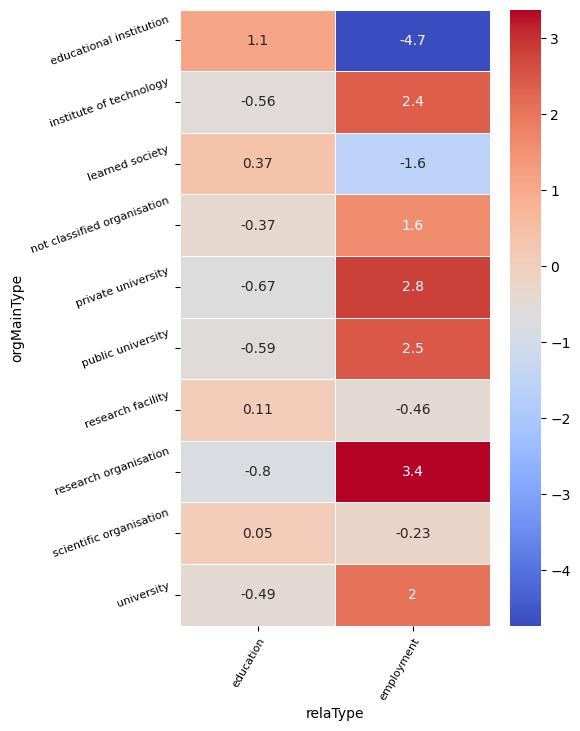

In [131]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

As said, we observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [132]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer', Series([], Name: uriPer, dtype: object)),
 ('labelPer', Series([], Name: labelPer, dtype: object)),
 ('birthYear', Series([], Name: birthYear, dtype: int64)),
 ('relaType', Series([], Name: relaType, dtype: object)),
 ('uriOrg', Series([], Name: uriOrg, dtype: object)),
 ('labelOrg', Series([], Name: labelOrg, dtype: object))]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [133]:


### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1901-1920,1921-1940,1941-1960,1961-1980,1981-2000,Total
orgMainType,,,,,,
educational institution,2,240,397,223,37,899
institute of technology,0,20,42,29,12,103
learned society,0,1,34,10,2,47
not classified organisation,0,3,5,4,1,13
private university,0,30,79,31,11,151
public university,0,16,76,43,16,151
research facility,0,0,2,1,1,4
research organisation,0,1,1,1,2,5
scientific organisation,0,0,1,0,0,1


In [134]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [135]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 76.05 , dof : 36
p-value : 0.00010935367803198431
phi2 = inertie (variance totale) : 0.038026223796657314
Cramer:  0.09750156895744976


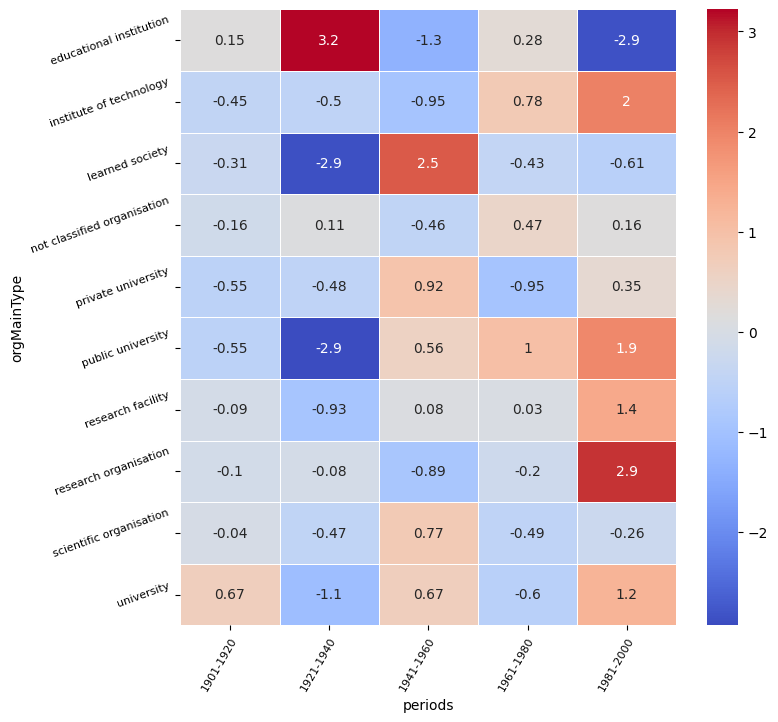

In [136]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [137]:


### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1901-1920,1921-1940,1941-1960,1961-1980,1981-2000,Total
relaType,,,,,,
education,4,419,875,474,122,1894
employment,0,15,69,13,9,106
Total,4,434,944,487,131,2000


In [138]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [139]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 18.11 , dof : 4
p-value : 0.0011718530738446663
phi2 = inertie (variance totale) : 0.009057486213358468
Cramer:  0.09517082648248079


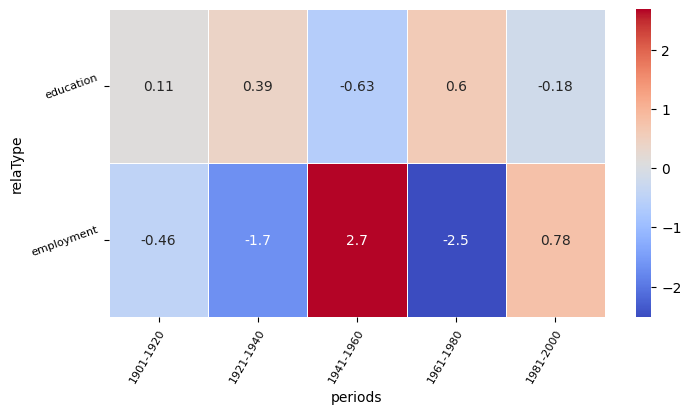

In [140]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [141]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


7236


In [142]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [143]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

2571
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y
299,http://www.wikidata.org/entity/Q109968497,Luke Delaney,1979,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,military university | open-access publisher | ...,university,education,1961-1980,http://www.wikidata.org/entity/Q7715757,The Basic School,census-designated place in the united states |...,educational institution,education
301,http://www.wikidata.org/entity/Q109968497,Luke Delaney,1979,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,military university | open-access publisher | ...,university,education,1961-1980,http://www.wikidata.org/entity/Q6764126,Marine Corps University,staff college | university,university,education
305,http://www.wikidata.org/entity/Q109968900,Jack Hathaway,1982,http://www.wikidata.org/entity/Q3428915,Empire Test Pilots' School,educational institution | flight school,educational institution,education,1981-2000,http://www.wikidata.org/entity/Q7568951,South Windsor High School,high school,educational institution,education
306,http://www.wikidata.org/entity/Q109968900,Jack Hathaway,1982,http://www.wikidata.org/entity/Q3428915,Empire Test Pilots' School,educational institution | flight school,educational institution,education,1981-2000,http://www.wikidata.org/entity/Q559549,United States Naval Academy,census-designated place in the united states |...,educational institution,education


In [144]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1894
employment     106
dtype: int64


In [145]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,education,education,2303
1,education,employment,124
2,employment,education,123
3,employment,employment,21


### Swap values in order to have the same orientation for all relationships

In [146]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [147]:
condition = merged.relaType_x > merged.relaType_y

In [148]:
### Transpose under condition

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [149]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y
299,http://www.wikidata.org/entity/Q109968497,Luke Delaney,1979,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,military university | open-access publisher | ...,university,education,1961-1980,http://www.wikidata.org/entity/Q7715757,The Basic School,census-designated place in the united states |...,educational institution,education
301,http://www.wikidata.org/entity/Q109968497,Luke Delaney,1979,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,military university | open-access publisher | ...,university,education,1961-1980,http://www.wikidata.org/entity/Q6764126,Marine Corps University,staff college | university,university,education
305,http://www.wikidata.org/entity/Q109968900,Jack Hathaway,1982,http://www.wikidata.org/entity/Q3428915,Empire Test Pilots' School,educational institution | flight school,educational institution,education,1981-2000,http://www.wikidata.org/entity/Q7568951,South Windsor High School,high school,educational institution,education
306,http://www.wikidata.org/entity/Q109968900,Jack Hathaway,1982,http://www.wikidata.org/entity/Q3428915,Empire Test Pilots' School,educational institution | flight school,educational institution,education,1981-2000,http://www.wikidata.org/entity/Q559549,United States Naval Academy,census-designated place in the united states |...,educational institution,education
307,http://www.wikidata.org/entity/Q109968900,Jack Hathaway,1982,http://www.wikidata.org/entity/Q3428915,Empire Test Pilots' School,educational institution | flight school,educational institution,education,1981-2000,http://www.wikidata.org/entity/Q575662,Naval War College,naval academy | staff college | university campus,university,education
308,http://www.wikidata.org/entity/Q109968900,Jack Hathaway,1982,http://www.wikidata.org/entity/Q181177,Cranfield University,educational organization | higher education in...,university,education,1981-2000,http://www.wikidata.org/entity/Q3428915,Empire Test Pilots' School,educational institution | flight school,educational institution,education
310,http://www.wikidata.org/entity/Q109968900,Jack Hathaway,1982,http://www.wikidata.org/entity/Q181177,Cranfield University,educational organization | higher education in...,university,education,1981-2000,http://www.wikidata.org/entity/Q7568951,South Windsor High School,high school,educational institution,education


In [150]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,education,education,2303
1,education,employment,247
2,employment,employment,21


In [151]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [152]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,relaType_concat
299,http://www.wikidata.org/entity/Q109968497,Luke Delaney,1979,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,military university | open-access publisher | ...,university,education,1961-1980,http://www.wikidata.org/entity/Q7715757,The Basic School,census-designated place in the united states |...,educational institution,education,education_education
301,http://www.wikidata.org/entity/Q109968497,Luke Delaney,1979,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,military university | open-access publisher | ...,university,education,1961-1980,http://www.wikidata.org/entity/Q6764126,Marine Corps University,staff college | university,university,education,education_education


In [153]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [154]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


2325


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
724,1941-1960,education_education,http://www.wikidata.org/entity/Q1331280,United States Air Force Academy,learned society,http://www.wikidata.org/entity/Q3428253,U.S. Air Force Test Pilot School,educational institution,Charles J. Precourt|Donald R. McMonagle|John C...,http://www.wikidata.org/entity/Q1065133|http:/...,19
620,1941-1960,education_education,http://www.wikidata.org/entity/Q1128819,United States Naval Test Pilot School,educational institution,http://www.wikidata.org/entity/Q559549,United States Naval Academy,educational institution,"Kenneth S. Reightler, Jr.|Robert D. Cabana|Ste...",http://www.wikidata.org/entity/Q1323571|http:/...,18
590,1941-1960,education_education,http://www.wikidata.org/entity/Q1128819,United States Naval Test Pilot School,educational institution,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,university,"Kenneth S. Reightler, Jr.|Kent Rominger|Robert...",http://www.wikidata.org/entity/Q1323571|http:/...,11
875,1941-1960,education_education,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,university,http://www.wikidata.org/entity/Q559549,United States Naval Academy,educational institution,"David Leestma|Kenneth S. Reightler, Jr.|Robert...",http://www.wikidata.org/entity/Q1174077|http:/...,10
1631,1961-1980,education_education,http://www.wikidata.org/entity/Q1128819,United States Naval Test Pilot School,educational institution,http://www.wikidata.org/entity/Q1515048,Naval Postgraduate School,university,Luke Delaney|Kenneth Ham|Stephen Frick|William...,http://www.wikidata.org/entity/Q109968497|http...,9


### Explore contingency table of relationship pairs to periods

In [155]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1901-1920,1921-1940,1941-1960,1961-1980,1981-2000,Total
relaType_concat,,,,,,
education_education,1,497,894,533,138,2063
education_employment,0,27,162,32,20,241
employment_employment,0,1,8,10,2,21
Total,1,525,1064,575,160,2325


In [156]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [157]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 65.43 , dof : 8
p-value : 3.968932607547399e-11
phi2 = inertie (variance totale) : 0.028141648179166465
Cramer:  0.11862050450737104


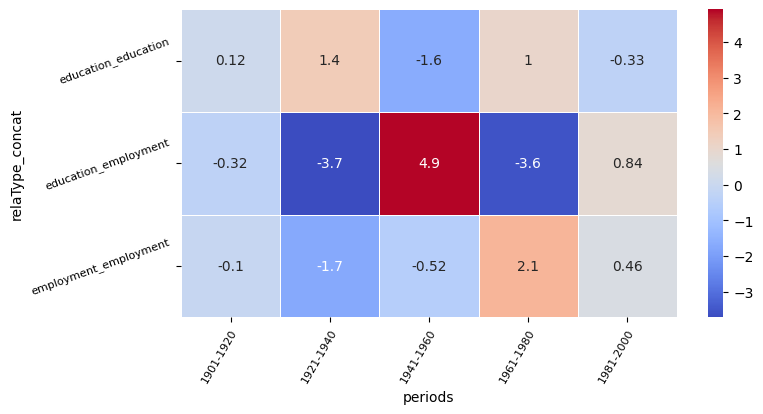

In [158]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects the relationships:

* which organisations are connected though education, but this will be only at the level of universities, not earlier education stage
* the same we will explore for memberships and employments, keeping them separated
* we will then ask what the relationship is between employment and membership
* and finally inspect if some kind of educational institutions (at unversity level, lead to specific employments or memberships)






### Organisations connected through higher education

In [159]:
print(df_mainTypes.mainType.to_list())

['educational institution', 'university', 'private university', 'public university', 'institute of technology', 'learned society', 'not classified organisation', 'research organisation', 'research facility', 'scientific organisation']


In [160]:
types_list=['university', 'public university', 'private university']

In [161]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

397


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
5,1921-1940,education_education,http://www.wikidata.org/entity/Q1048898,University of Vermont,university,http://www.wikidata.org/entity/Q193727,Johns Hopkins University,university,Duane Graveline,http://www.wikidata.org/entity/Q3499300,1
6,1921-1940,education_education,http://www.wikidata.org/entity/Q1068072,University of Delaware,public university,http://www.wikidata.org/entity/Q230492,University of Michigan,university,Theodore Freeman,http://www.wikidata.org/entity/Q634141,1


In [162]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
1271,1941-1960,education_education,http://www.wikidata.org/entity/Q49115,Cornell University,private university,http://www.wikidata.org/entity/Q5171564,Cornell University College of Engineering,university,Daniel T. Barry|Donald A. Thomas|Jay C. Buckey...,http://www.wikidata.org/entity/Q1162918|http:/...,4
1606,1961-1980,education_education,http://www.wikidata.org/entity/Q10873057,PLA Air Force Aviation University,university,http://www.wikidata.org/entity/Q16955,Tsinghua University,public university,Yang Liwei|Liu Yang|Jing Haipeng,http://www.wikidata.org/entity/Q147581|http://...,3


In [163]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1921-1940     69
1941-1960    206
1961-1980     92
1981-2000     30
dtype: int64


### Inspect a specific period

In [204]:
p = '1901-1920' #'1851-1900' #'1921-1940'

In [205]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number


In [206]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

0


In [210]:
#control liste d'arrêtes
if not l:
    print("Liste d'arêtes vide, graphe nul")
else:
    edu_graph_p.add_edges_from(l)


Liste d'arêtes vide, graphe nul


In [211]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

NetworkXPointlessConcept: Connectivity is undefined for the null graph.

In [170]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

KeyError: 1

In [171]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

NameError: name 'edu_graph_p_S' is not defined

In [172]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
35,http://www.wikidata.org/entity/Q1128819,United States Naval Test Pilot School,educational institution,1941-1960,43
419,http://www.wikidata.org/entity/Q3428253,U.S. Air Force Test Pilot School,educational institution,1941-1960,41


In [173]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
0,http://www.wikidata.org/entity/Q102398197,"Faculty of Law, German University in Prague",university,1
344,http://www.wikidata.org/entity/Q238101,University of Minnesota,university,1
465,http://www.wikidata.org/entity/Q4129735,Higher school of glider flying,educational institution,1
650,http://www.wikidata.org/entity/Q5061177,Central High School,educational institution,1


In [174]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


NameError: name 'pG' is not defined

In [175]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
mn_s.groupby(by=mn_s).size().sort_values(ascending=False)


NameError: name 'pG' is not defined

####  Create dataframe and inspect node properties

In [176]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

NameError: name 'pG' is not defined

In [177]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


NameError: name 'pG' is not defined

In [178]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


NameError: name 'pG' is not defined

In [179]:
### List found on p. 121, some colors added
col_list = [
('university', 'DarkSeaGreen'), 
('public university', 'red'), 
('private university', 'DeepSkyBlue')
]
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'private university': 'DeepSkyBlue',
 'public university': 'red',
 'university': 'DarkSeaGreen'}


In [180]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.98]).item()
    test_v2 = df[value_2].quantile([0.98]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items()],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

In [181]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(5,4), 
                          legend_loc='upper right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

NameError: name 'nodes_df' is not defined

In [182]:
list(nodes_df.columns)

NameError: name 'nodes_df' is not defined

In [183]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness


NameError: name 'nodes_df' is not defined

#### Plot graph

In [213]:
pict_addr = 'images/organisations/edu_edu_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1901-1920.svg


In [214]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=8, alpha=alpha_n
                        )
                        for label, color in color_map.items()],
                        loc='lower right', fontsize=8)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


NameError: name 'pG' is not defined

### Communitites

In [215]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


NameError: name 'pG' is not defined

In [187]:
for i in range(0,5):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))




Community 0 
Betweenness


NameError: name 'nodes_df' is not defined

#### Plot communitites graph

In [188]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

images/organisations/edu_edu_communities_1901-1920.svg


In [189]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


NameError: name 'pG' is not defined

## Create general function

In [190]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [191]:
print(df_mainTypes.mainType.to_list())

['educational institution', 'university', 'private university', 'public university', 'institute of technology', 'learned society', 'not classified organisation', 'research organisation', 'research facility', 'scientific organisation']


In [192]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

FileNotFoundError: [Errno 2] No such file or directory: 'analysis_doc/education_education.md'

In [193]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

FileNotFoundError: [Errno 2] No such file or directory: 'analysis_doc/membership_membership.md'

In [194]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

FileNotFoundError: [Errno 2] No such file or directory: 'analysis_doc/employment_employment.md'